In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import altair as alt
from datetime import datetime

from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import shap

In [2]:
stocks = pd.read_csv('Data/stocks_top500.csv')
power = pd.read_csv('Data/powerconsumption.csv')

In [4]:
stocks.head()

,sympbol,name,sector,price,price_earnings,dividend_yield,earnings_share,week_low_52,week_high_52,market_cap,ebitda,price_sales,price_book
0,MMM,3M Company,Industrials,222.89,24.31,2.332862,7.92,259.77,175.490,1.387210e+11,9.048000e+09,4.390271,11.34
1,AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.147959,1.70,68.39,48.925,1.078342e+10,6.010000e+08,3.575483,6.35
2,ABT,Abbott Laboratories,Health Care,56.27,22.51,1.908982,0.26,64.60,42.280,1.021210e+11,5.744000e+09,3.740480,3.19
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.050,1.813860e+11,1.031000e+10,6.291571,26.14
4,ACN,Accenture plc,Information Technology,150.51,25.47,1.714470,5.44,162.60,114.820,9.876586e+10,5.643228e+09,2.604117,10.62


In [5]:
power.head()

,date_time,temperature,humidity,windspeed,general_diffuse_flows,diffuse_flows,power_consumption_zone1,power_consumption_zone2,power_consumption_zone3
0,1/1/17 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/17 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/17 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/17 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/17 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [6]:
power.dtypes

date_time                   object
temperature                float64
humidity                   float64
windspeed                  float64
general_diffuse_flows      float64
diffuse_flows              float64
power_consumption_zone1    float64
power_consumption_zone2    float64
power_consumption_zone3    float64
dtype: object

# Multivariate, Point-in-Time Data
## Statistical Methods - Stocks
### IQR

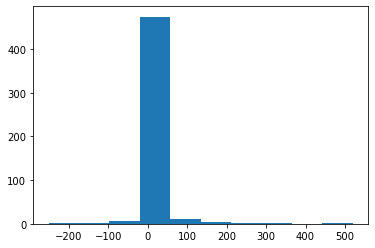

In [7]:
# Histogram of price-to-earnings ratio
plt.hist(stocks['price_earnings'])
plt.show() 

In [8]:
#calculate interquartile range 
q3, q1 = np.nanpercentile(stocks['price_earnings'], [75 ,25])
iqr = q3 - q1
iqr

10.4

In [9]:
iqr_lower = q1 - 1.5 * iqr
iqr_upper = q3 + 1.5 * iqr
print("IQR Lower Bound is: ", iqr_lower)
print("IQR Upper Bound is: ", iqr_upper)

IQR Lower Bound is:  -0.2500000000000018
IQR Upper Bound is:  41.35


In [10]:
def iqr_outlier_label(column, lower, upper):
    if (column < lower):
        return 'Low Outlier'
    elif (column > upper):
        return 'High Outlier'
    elif ((column >= lower) & (column <= upper)):
        return 'Not an Outlier'

stocks['outlier_label_iqr'] = stocks.apply(lambda x: iqr_outlier_label(x.price_earnings, iqr_lower, iqr_upper), axis=1)

In [11]:
stocks.groupby('outlier_label_iqr')['sympbol'].count()

outlier_label_iqr
High Outlier       36
Low Outlier        11
Not an Outlier    456
Name: sympbol, dtype: int64

### Z-Scores

In [12]:
stocks['zscore_price_earn'] = stats.zscore(stocks['price_earnings'], nan_policy='omit')

In [13]:
stocks['zscore_price_earn'].describe()

count    5.030000e+02
mean     1.390538e-17
std      1.000996e+00
min     -6.707232e+00
25%     -2.295722e-01
50%     -1.300578e-01
75%      2.285458e-02
max      1.202284e+01
Name: zscore_price_earn, dtype: float64

In [14]:
def zscore_outlier_label(column):
    if column < -3:
        return 'Low Outlier'
    elif column > 3:
        return 'High Outlier'
    elif ((column >= -3) | (column <= 3)):
        return 'Not an Outlier'
    
stocks['outlier_label_zscore'] = stocks.zscore_price_earn.apply(zscore_outlier_label)

In [15]:
stocks.groupby('outlier_label_zscore')['sympbol'].count()

outlier_label_zscore
High Outlier       10
Low Outlier         2
Not an Outlier    491
Name: sympbol, dtype: int64

In [16]:
stocks.columns

Index(['sympbol', 'name', 'sector', 'price', 'price_earnings',
       'dividend_yield', 'earnings_share', 'week_low_52', 'week_high_52',
       'market_cap', 'ebitda', 'price_sales', 'price_book',
       'outlier_label_iqr', 'zscore_price_earn', 'outlier_label_zscore'],
      dtype='object')

## Isolation Forest

In [17]:
input_columns = ['price', 'price_earnings', 'dividend_yield', 'earnings_share']
stocks_modeling = stocks[input_columns]

imputer = SimpleImputer(strategy='median')
isofor = IsolationForest(random_state=0, max_features=3)

iso_pipe = Pipeline(steps=[('imputer', imputer), ('isolation_forest', isofor)])
iso_fit_pipe = iso_pipe.fit(stocks_modeling)
iso_outliers = iso_pipe.predict(stocks_modeling)

In [18]:
stocks['outlier_label_isofor'] = iso_outliers
stocks.groupby(['outlier_label_zscore','outlier_label_isofor'])['sympbol'].count()

outlier_label_zscore  outlier_label_isofor
High Outlier          -1                       10
Low Outlier           -1                        2
Not an Outlier        -1                       21
                       1                      470
Name: sympbol, dtype: int64

#### All outliers identified with the z-score method were identified with isolation forest

In [19]:
stocks['outlier_label_isofor'] = iso_outliers
stocks.groupby(['outlier_label_iqr','outlier_label_isofor'])['sympbol'].count()

outlier_label_iqr  outlier_label_isofor
High Outlier       -1                       11
                    1                       25
Low Outlier        -1                        5
                    1                        6
Not an Outlier     -1                       17
                    1                      439
Name: sympbol, dtype: int64

#### Using the IQR method there are mixed results isolation forest

### Belowing showing SHAP explainers on our Isolation Forest Model

In [20]:
f = lambda x: iso_fit_pipe.decision_function(x)
explainer = shap.Explainer(f, stocks_modeling, feature_names=input_columns)
shap_values = explainer(stocks_modeling)

Exact explainer: 506it [00:49,  8.52it/s]                                       


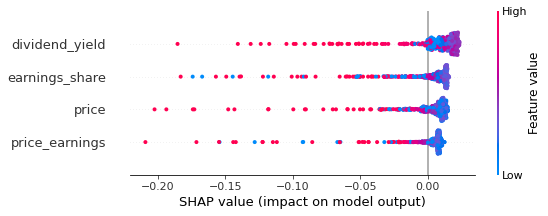

In [21]:
shap.summary_plot(shap_values, feature_names=input_columns)

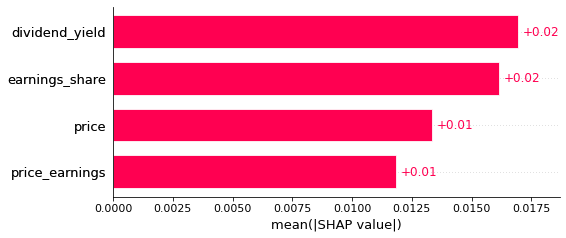

In [22]:
shap.plots.bar(shap_values, max_display=14)

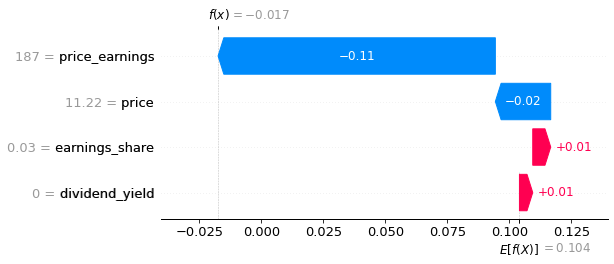

In [23]:
# Example of an anomaly explanation
shap.plots.waterfall(shap_values[9])

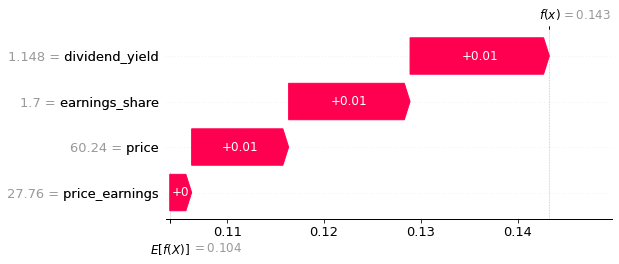

In [24]:
# Example of an non-anomaly explanation
shap.plots.waterfall(shap_values[1])

## DBSCAN Method

In [25]:
scaler = StandardScaler()
dbscan=DBSCAN(eps=1.3)

dbscan_pipe = Pipeline(steps=[('imputer', imputer), ('standard_scaler', scaler), ('DBSCAN', dbscan)])
dbscan_fit_pipe = dbscan_pipe.fit(stocks_modeling)

In [26]:
stocks['dbscan_clusters'] = pd.Series(dbscan_fit_pipe[2].labels_)
stocks['dbscan_clusters'].value_counts()

 0    477
-1     28
Name: dbscan_clusters, dtype: int64

In [27]:
stocks['outlier_label_dbscan'] = stocks['dbscan_clusters'].apply(lambda x: 'Outlier' if x==-1 else 'Not an Outlier')
stocks.groupby(['outlier_label_zscore','outlier_label_dbscan'])['sympbol'].count()

outlier_label_zscore  outlier_label_dbscan
High Outlier          Outlier                  10
Low Outlier           Outlier                   2
Not an Outlier        Not an Outlier          476
                      Outlier                  15
Name: sympbol, dtype: int64

In [28]:
stocks['outlier_label_dbscan'] = stocks['dbscan_clusters'].apply(lambda x: 'Outlier' if x==-1 else 'Not an Outlier')
stocks.groupby(['outlier_label_iqr','outlier_label_dbscan'])['sympbol'].count()

outlier_label_iqr  outlier_label_dbscan
High Outlier       Not an Outlier           25
                   Outlier                  11
Low Outlier        Not an Outlier            5
                   Outlier                   6
Not an Outlier     Not an Outlier          446
                   Outlier                  10
Name: sympbol, dtype: int64

### DBSCAN not effective at identifying outliers

# Time Series Data

In [29]:
power.head()

power['ds'] = pd.to_datetime(power['date_time'])
power['date'] = power['ds'].dt.date

#### Visualization of power consumption zone 1

<AxesSubplot:xlabel='date'>

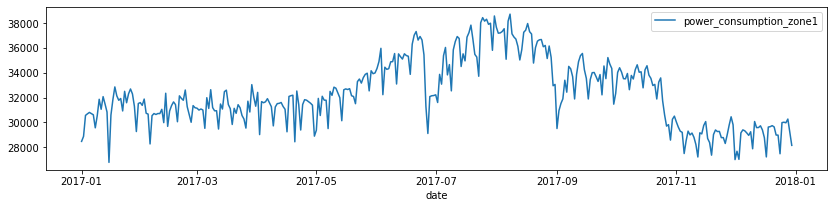

In [31]:
plt.rcParams["figure.figsize"] = (14,3)

power_date_avg1 = power.groupby('date')['power_consumption_zone1'].mean()
power_date_avg1 = power_date_avg1.reset_index()

power_date_avg1[['date','power_consumption_zone1']].plot(x='date')

#### Visualization of power consumption zone 2

<AxesSubplot:xlabel='date'>

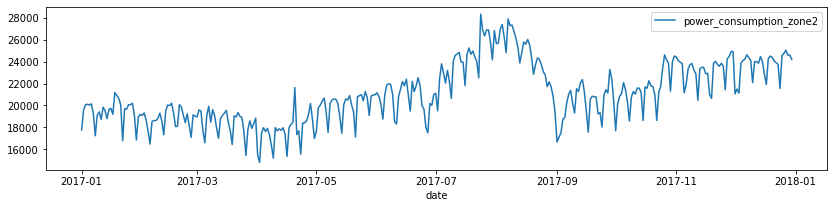

In [32]:
power_date_avg2 = power.groupby('date')['power_consumption_zone2'].mean()
power_date_avg2 = power_date_avg2.reset_index()

power_date_avg2[['date','power_consumption_zone2']].plot(x='date')

#### Visualization of power consumption zone 3

<AxesSubplot:xlabel='date'>

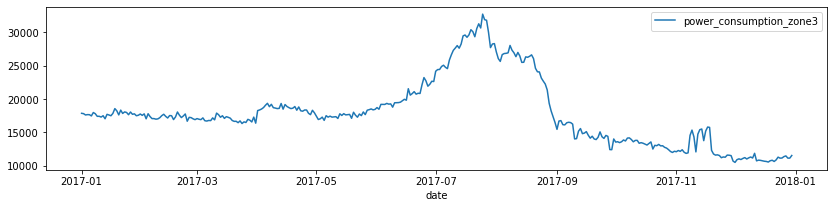

In [33]:
power_date_avg3 = power.groupby('date')['power_consumption_zone3'].mean()
power_date_avg3 = power_date_avg3.reset_index()

power_date_avg3[['date','power_consumption_zone3']].plot(x='date')

### Power Zone 1

In [34]:
column_of_interest = 'power_consumption_zone1'

power_modeling = power.copy()

power_modeling.rename(columns={column_of_interest:'y'},inplace=True)
power_modeling.head()

# Running Prophet models
m = Prophet()
# Fitting the model
m.fit(power_modeling)
# Making a data frame of the size of 92 days, the length of our validation data set
future = m.make_future_dataframe(periods=0)
# Use fitted model to make the predictions
forecast = m.predict(future)
forecast['y'] = power_modeling['y']

19:15:15 - cmdstanpy - INFO - Chain [1] start processing
19:15:45 - cmdstanpy - INFO - Chain [1] done processing


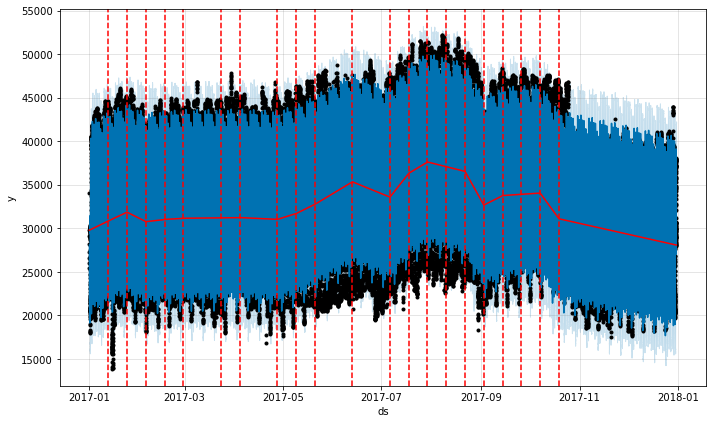

In [35]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

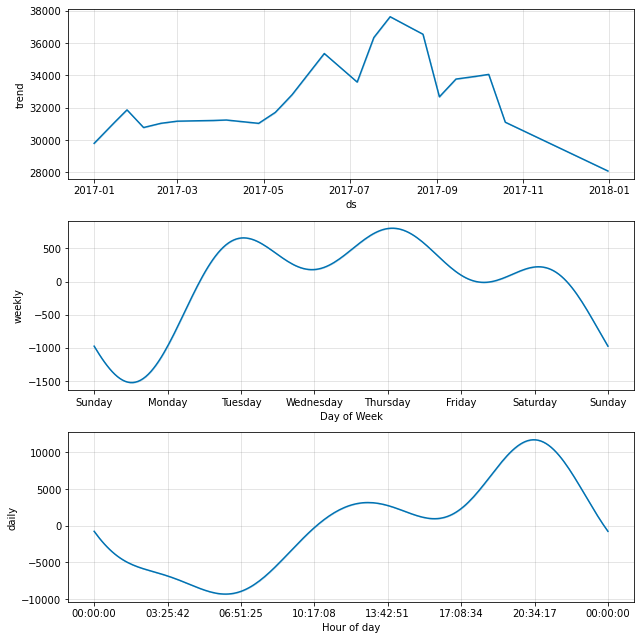

In [36]:
fig2 = m.plot_components(forecast)

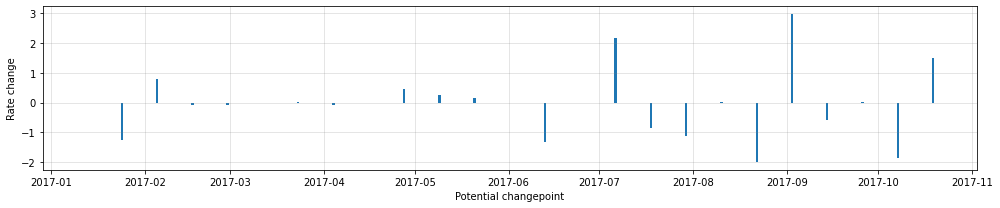

In [37]:
deltas = pd.concat([pd.DataFrame([m.changepoints]).T.reset_index(), pd.DataFrame(m.params['delta'][0])], axis=1).drop(columns='index')
deltas.rename(columns={0:'deltas'},inplace=True)

plt.rcParams["figure.figsize"] = (14,3)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(deltas['ds'],deltas['deltas'])
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

In [38]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'y']].copy()

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['y'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['y'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['y'] - forecasted['yhat_upper'])/forecast['y']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['y'])/forecast['y']
    
    return forecasted

pred = detect_anomalies(forecast)

In [39]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
0,2017-01-01 00:00:00,29796.598194,24661.348775,31430.514494,29796.598194,29796.598194,-1732.070841,-1732.070841,-1732.070841,-758.242737,-758.242737,-758.242737,-973.828104,-973.828104,-973.828104,0.0,0.0,0.0,28064.527353,34055.69620
1,2017-01-01 00:10:00,29797.225898,24055.563946,30619.058899,29797.225898,29797.225898,-2392.980624,-2392.980624,-2392.980624,-1406.399637,-1406.399637,-1406.399637,-986.580987,-986.580987,-986.580987,0.0,0.0,0.0,27404.245273,29814.68354
2,2017-01-01 00:20:00,29797.853601,23186.373093,30123.746804,29797.853601,29797.853601,-3007.926056,-3007.926056,-3007.926056,-2008.666174,-2008.666174,-2008.666174,-999.259882,-999.259882,-999.259882,0.0,0.0,0.0,26789.927545,29128.10127
3,2017-01-01 00:30:00,29798.481305,22804.632922,29513.136032,29798.481305,29798.481305,-3574.874101,-3574.874101,-3574.874101,-2563.012767,-2563.012767,-2563.012767,-1011.861334,-1011.861334,-1011.861334,0.0,0.0,0.0,26223.607204,28228.86076
4,2017-01-01 00:40:00,29799.109009,22345.062213,29108.631850,29799.109009,29799.109009,-4092.898893,-4092.898893,-4092.898893,-3068.516995,-3068.516995,-3068.516995,-1024.381898,-1024.381898,-1024.381898,0.0,0.0,0.0,25706.210116,27335.69620


There is too much data in this case but if you want code on how to plot time series anomalies with prophet go to this link: https://towardsdatascience.com/anomaly-detection-time-series-4c661f6f165f

In [40]:
pred.head()

,ds,trend,yhat,yhat_lower,yhat_upper,y,anomaly,importance
0,2017-01-01 00:00:00,29796.598194,28064.527353,24661.348775,31430.514494,34055.69620,1,0.077085
1,2017-01-01 00:10:00,29797.225898,27404.245273,24055.563946,30619.058899,29814.68354,0,0.000000
2,2017-01-01 00:20:00,29797.853601,26789.927545,23186.373093,30123.746804,29128.10127,0,0.000000
3,2017-01-01 00:30:00,29798.481305,26223.607204,22804.632922,29513.136032,28228.86076,0,0.000000
4,2017-01-01 00:40:00,29799.109009,25706.210116,22345.062213,29108.631850,27335.69620,0,0.000000


In [41]:
pred['anomaly'].value_counts()

 0    44680
-1     3950
 1     3786
Name: anomaly, dtype: int64

In [42]:
pred.sort_values('importance', ascending=False).head(20)

,ds,trend,yhat,yhat_lower,yhat_upper,y,anomaly,importance
15769,2017-04-20 12:10:00,31092.163089,34599.297820,31232.674705,37893.003071,16814.98385,-1,0.857431
15770,2017-04-20 12:20:00,31092.098669,34692.991282,31563.123032,38096.322593,17794.61787,-1,0.773745
25458,2017-06-26 19:00:00,34308.660437,43418.672250,40256.054849,46713.266497,27388.60927,-1,0.469810
25457,2017-06-26 18:50:00,34309.186286,42812.558229,39669.366191,46320.569804,27216.95364,-1,0.457524
25459,2017-06-26 19:10:00,34308.134588,43997.006252,40760.700977,47413.435972,28062.51656,-1,0.452496
25456,2017-06-26 18:40:00,34309.712135,42188.160598,39004.234983,45284.315086,27305.96026,-1,0.428415
25460,2017-06-26 19:20:00,34307.608739,44538.206236,41243.684173,47793.880262,28901.72185,-1,0.427032
25461,2017-06-26 19:30:00,34307.082891,45033.240180,41789.404204,48214.293571,29791.78808,-1,0.402716
25455,2017-06-26 18:30:00,34310.237984,41554.939750,38370.365647,44651.618918,27477.61589,-1,0.396423
25602,2017-06-27 19:00:00,34232.938201,43011.299219,39826.575901,46249.945372,28660.13245,-1,0.389616


### Power Zone 2

In [286]:
column_of_interest = 'power_consumption_zone2'

power_modeling = power.copy()

power_modeling.rename(columns={column_of_interest:'y'},inplace=True)
power_modeling.head()

# Running Prophet models
m = Prophet()
# Fitting the model
m.fit(power_modeling)
# Making a data frame of the size of 92 days, the length of our validation data set
future = m.make_future_dataframe(periods=0)
# Use fitted model to make the predictions
forecast = m.predict(future)
forecast['y'] = power_modeling['y']

20:45:11 - cmdstanpy - INFO - Chain [1] start processing
20:45:43 - cmdstanpy - INFO - Chain [1] done processing


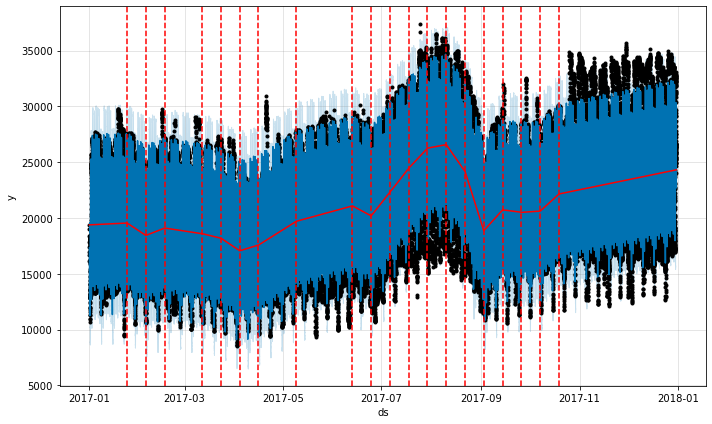

In [287]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

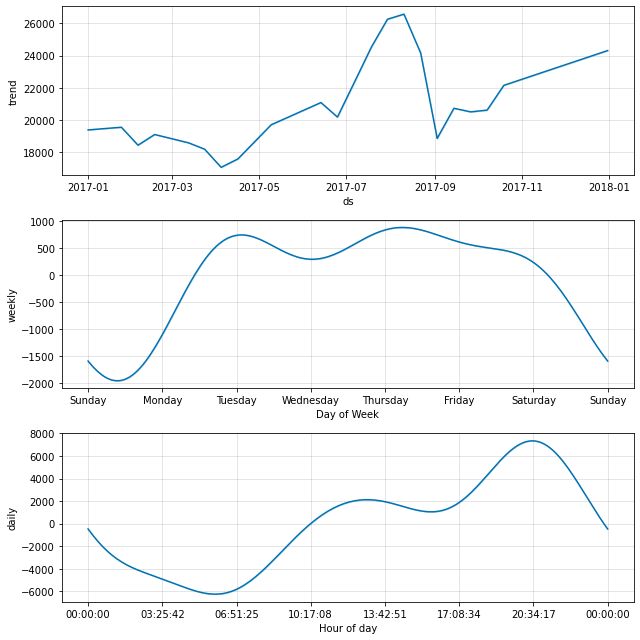

In [288]:
fig2 = m.plot_components(forecast)

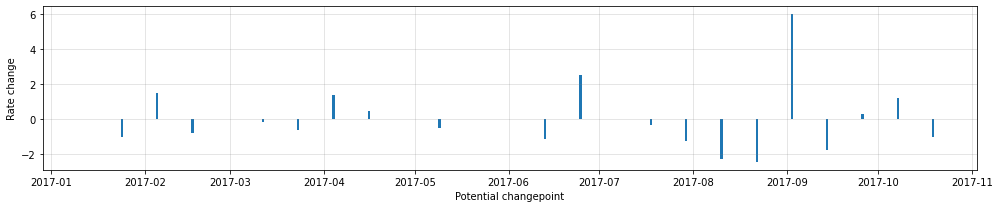

In [289]:
deltas = pd.concat([pd.DataFrame([m.changepoints]).T.reset_index(), pd.DataFrame(m.params['delta'][0])], axis=1).drop(columns='index')
deltas.rename(columns={0:'deltas'},inplace=True)

plt.rcParams["figure.figsize"] = (14,3)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(deltas['ds'],deltas['deltas'])
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

In [290]:
pred = detect_anomalies(forecast)

In [291]:
pred['anomaly'].value_counts()

 0    44217
-1     4117
 1     4082
Name: anomaly, dtype: int64

In [292]:
pred.sort_values('importance', ascending=False).head(20)

,ds,trend,yhat,yhat_lower,yhat_upper,y,anomaly,importance
25459,2017-06-26 19:10:00,20557.451261,27014.010478,24778.171292,29554.592564,16293.55509,-1,0.520734
25458,2017-06-26 19:00:00,20556.192281,26671.681874,24058.667263,29113.675854,15964.24116,-1,0.507035
25457,2017-06-26 18:50:00,20554.933301,26313.149387,23822.938901,28777.920204,15941.78794,-1,0.494371
25456,2017-06-26 18:40:00,20553.674322,25943.997634,23435.173704,28466.205397,15702.28690,-1,0.492469
25460,2017-06-26 19:20:00,20558.710240,27334.609174,24684.039910,29812.099483,16581.70478,-1,0.488631
25455,2017-06-26 18:30:00,20552.415342,25569.765503,23088.166247,27929.343568,15795.84200,-1,0.461661
25461,2017-06-26 19:30:00,20559.969220,27628.116166,25168.043556,30181.222944,17345.11435,-1,0.451016
25454,2017-06-26 18:20:00,20551.156362,25195.845507,22673.897103,27749.002494,15777.13098,-1,0.437137
25453,2017-06-26 18:10:00,20549.897383,24827.388980,22208.894246,27142.283774,15773.38877,-1,0.407998
25452,2017-06-26 18:00:00,20548.638403,24469.219143,22042.596356,26834.663801,15915.59252,-1,0.384969


### Power Zone 3

In [293]:
column_of_interest = 'power_consumption_zone3'

power_modeling = power.copy()

power_modeling.rename(columns={column_of_interest:'y'},inplace=True)
power_modeling.head()

# Running Prophet models
m = Prophet()
# Fitting the model
m.fit(power_modeling)
# Making a data frame of the size of 92 days, the length of our validation data set
future = m.make_future_dataframe(periods=0)
# Use fitted model to make the predictions
forecast = m.predict(future)
forecast['y'] = power_modeling['y']

20:46:42 - cmdstanpy - INFO - Chain [1] start processing
20:47:10 - cmdstanpy - INFO - Chain [1] done processing


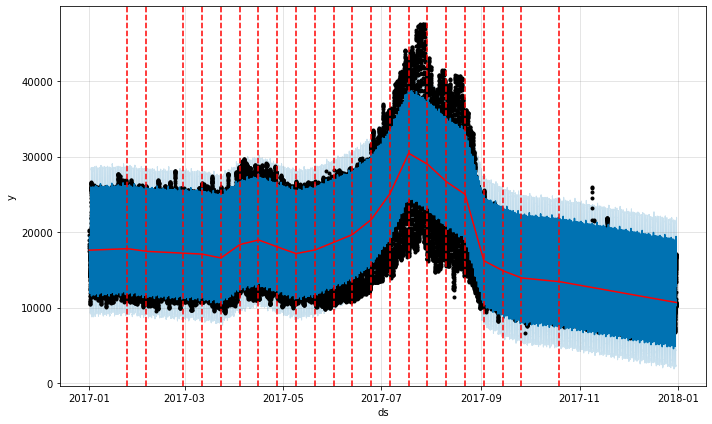

In [294]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

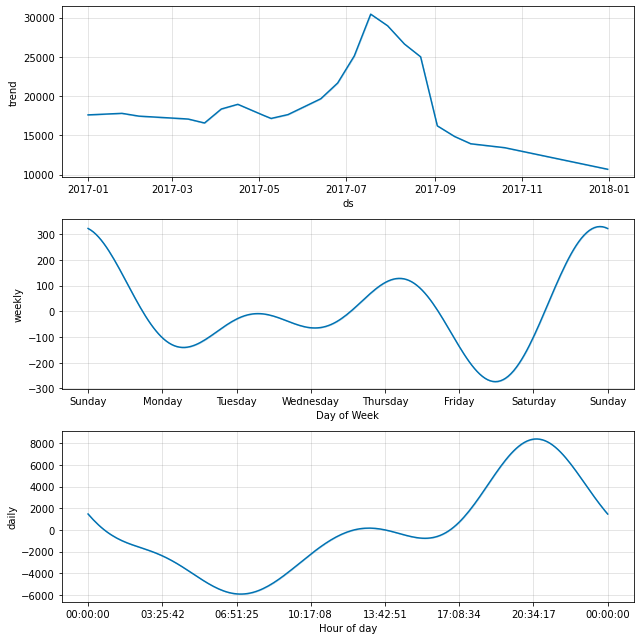

In [295]:
fig2 = m.plot_components(forecast)

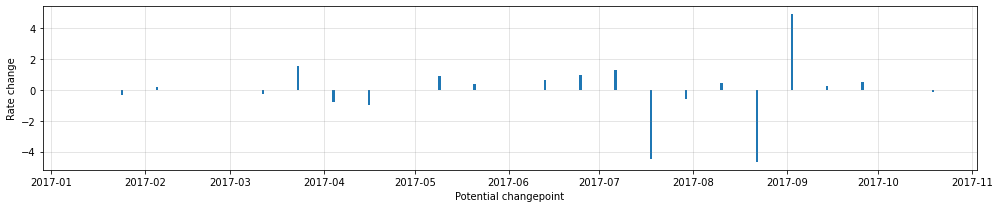

In [296]:
deltas = pd.concat([pd.DataFrame([m.changepoints]).T.reset_index(), pd.DataFrame(m.params['delta'][0])], axis=1).drop(columns='index')
deltas.rename(columns={0:'deltas'},inplace=True)

plt.rcParams["figure.figsize"] = (14,3)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(deltas['ds'],deltas['deltas'])
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

In [297]:
pred = detect_anomalies(forecast)

In [298]:
pred['anomaly'].value_counts()

 0    43131
 1     4793
-1     4492
Name: anomaly, dtype: int64

In [299]:
pred.sort_values('importance', ascending=False).head(20)

,ds,trend,yhat,yhat_lower,yhat_upper,y,anomaly,importance
32581,2017-08-15 06:10:00,25987.694159,20409.380110,17926.912127,22932.166986,11351.47335,-1,0.579259
32582,2017-08-15 06:20:00,25986.705212,20287.278153,17868.186528,22875.810890,12398.74608,-1,0.441129
32580,2017-08-15 06:00:00,25988.683105,20552.631043,18150.295995,23191.996384,12699.68652,-1,0.429192
32437,2017-08-14 06:10:00,26130.102456,20420.697555,17969.241870,22996.277611,12603.38558,-1,0.425747
32438,2017-08-14 06:20:00,26129.113510,20298.345827,17694.451348,22693.943151,12531.15987,-1,0.412036
32436,2017-08-14 06:00:00,26131.091403,20564.265880,18128.002695,23117.606192,12844.13793,-1,0.411383
30850,2017-08-03 05:40:00,28098.949260,23139.084241,20661.875047,25730.003634,14758.11912,-1,0.400034
32583,2017-08-15 06:30:00,25985.716266,20188.147549,17534.778871,22511.656573,12543.19749,-1,0.397951
32584,2017-08-15 06:40:00,25984.727319,20113.485603,17599.214541,22744.327165,12693.66771,-1,0.386456
32585,2017-08-15 06:50:00,25983.738373,20064.443763,17679.499115,22617.023073,12868.21317,-1,0.373889
